# 1) Importing Libraries

In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# sklearn imports
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
import joblib

# plotting style
sns.set_theme(style="whitegrid")
%matplotlib inline

# 2) Load the data

In [79]:
TRAIN_PATH = "../data/train.csv"
TEST_PATH = "../data/test.csv"

train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)

print("Train shape:", train.shape)
print("Test shape:", test.shape)


Train shape: (891, 12)
Test shape: (418, 11)


# 3) Quick look at the data (head, info, missing values)


In [80]:
display(train.head())
print("\nInfo")
print(train.info())
print("\nMissing values (train)")
print(train.isnull().sum().sort_values(ascending=False).head(10))

print("\nMissing values (test)")
print(test.isnull().sum().sort_values(ascending=False).head(10))


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S



Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None

Missing values (train)
Cabin          687
Age            177
Embarked         2
PassengerId      0
Name             0
Pclass           0
Survived         0
Sex              0
Parch            0
SibSp            0
dtype: int64

Missi

# 4) Target distribution & basic EDA

Inspect survival balance and some univariate distributions.


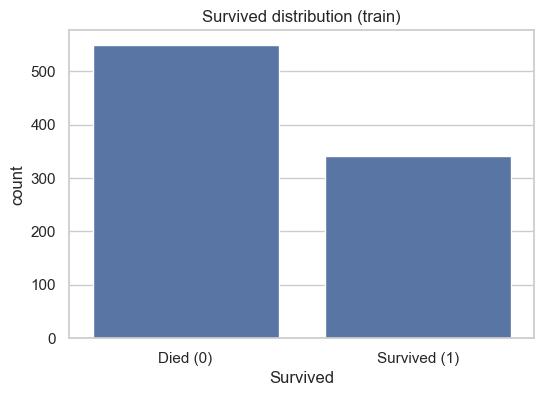

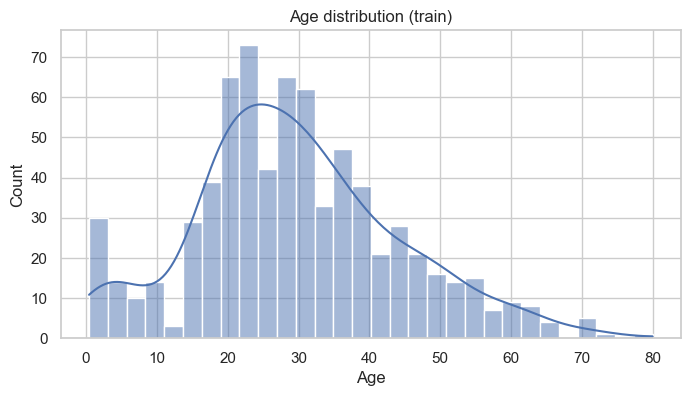

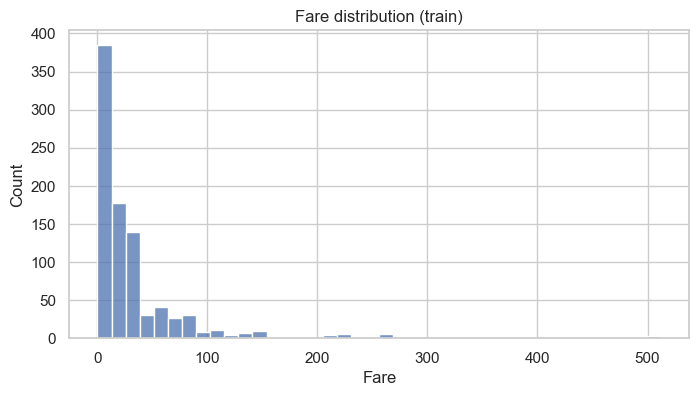

In [81]:
# Target distribution
plt.figure(figsize=(6,4))
sns.countplot(x='Survived', data=train)
plt.title("Survived distribution (train)")
plt.xticks([0,1], ["Died (0)", "Survived (1)"])
plt.show()

# Age distribution
plt.figure(figsize=(8,4))
sns.histplot(train['Age'].dropna(), kde=True, bins=30)
plt.title("Age distribution (train)")
plt.show()

# Fare distribution (log-scale for visualization)
plt.figure(figsize=(8,4))
sns.histplot(train['Fare'].dropna(), bins=40)
plt.title("Fare distribution (train)")
plt.show()


# 5) Bivariate analysis: features vs target

See how sex, class, embarcation relate to survival.


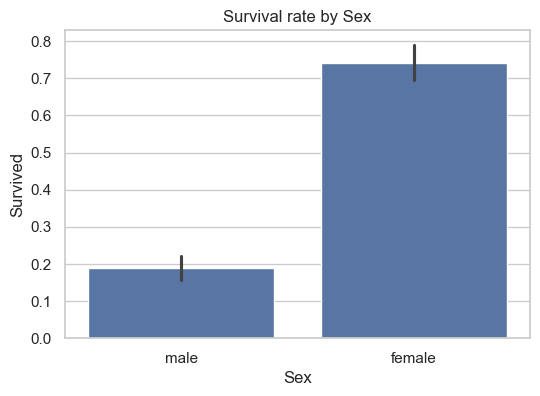

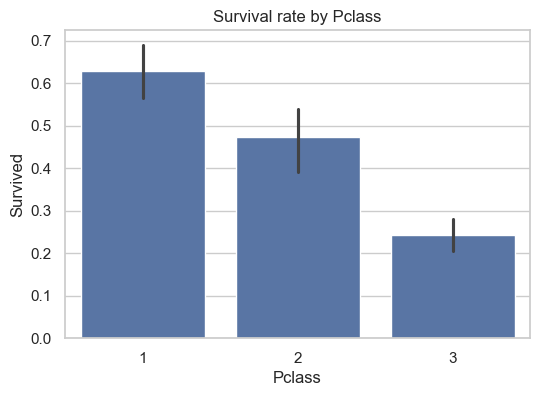

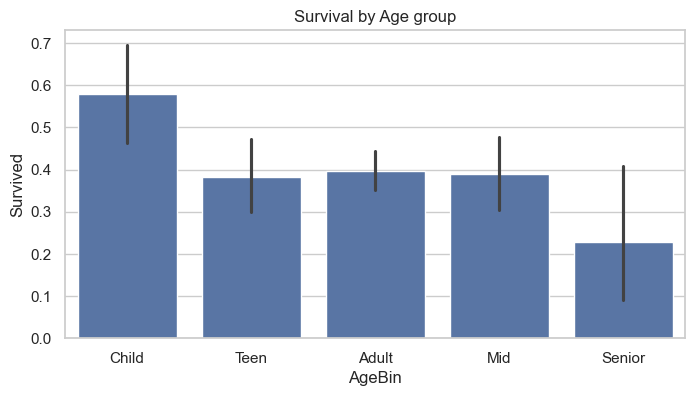

In [82]:
# Survival by Sex
plt.figure(figsize=(6,4))
sns.barplot(x='Sex', y='Survived', data=train)
plt.title("Survival rate by Sex")
plt.show()

# Survival by Pclass
plt.figure(figsize=(6,4))
sns.barplot(x='Pclass', y='Survived', data=train)
plt.title("Survival rate by Pclass")
plt.show()

# Survival vs Age (age bins)
train['AgeBin'] = pd.cut(train['Age'], bins=[0,12,20,40,60,80], labels=['Child','Teen','Adult','Mid','Senior'])
plt.figure(figsize=(8,4))
sns.barplot(x='AgeBin', y='Survived', data=train, order=['Child','Teen','Adult','Mid','Senior'])
plt.title("Survival by Age group")
plt.show()
train.drop(columns=['AgeBin'], inplace=True)


# 6) Feature engineering: create helpful features

- `Title` from Name (Mr, Mrs, Miss, Master, Rare)
- `FamilySize` = SibSp + Parch + 1
- `IsAlone` from FamilySize

In [83]:
def extract_title(name):
    if pd.isna(name):
        return "None"
    title = name.split(',')[1].split('.')[0].strip()
    return title

def simplify_title(title):
    title = title.lower()
    if title in ['mr', 'mrs', 'miss', 'master']:
        return title.title()
    if title in ['ms']:
        return 'Miss'
    if title in ['mme', 'mademoiselle']:
        return 'Mrs'
    return 'Rare'

def add_features(df):
    df = df.copy()
    df['Title'] = df['Name'].apply(extract_title).apply(simplify_title)
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    df['IsAlone'] = (df['FamilySize'] == 1).astype(int)
    return df

train_fe = add_features(train)
test_fe = add_features(test)

print("Titles in train:", train_fe['Title'].value_counts())
display(train_fe[['Title','FamilySize','IsAlone']].head())


Titles in train: Title
Mr        517
Miss      183
Mrs       126
Master     40
Rare       25
Name: count, dtype: int64


,Title,FamilySize,IsAlone
0,Mr,2,0
1,Mrs,2,0
2,Miss,1,1
3,Mrs,2,0
4,Mr,1,1


# 7) Handle missing values with domain-specific logic

In [84]:
train_clean = train_fe.copy()
test_clean = test_fe.copy()

# Embarked -> fill with mode
for df in [train_clean, test_clean]:
    if 'Embarked' in df.columns:
        df['Embarked']=df['Embarked'].fillna(df['Embarked'].mode()[0])

# Fare -> fill with median (test may have missing Fare)
test_clean['Fare']=test_clean['Fare'].fillna(test_clean['Fare'].median())

# Age -> fill by Title median
title_age_median = train_clean.groupby('Title')['Age'].median()
# fallback median
overall_age_median = train_clean['Age'].median()

def fill_age_by_title(row):
    if pd.notna(row['Age']):
        return row['Age']
    title = row['Title']
    if pd.notna(title) and title in title_age_median.index and pd.notna(title_age_median.loc[title]):
        return title_age_median.loc[title]
    return overall_age_median

train_clean['Age'] = train_clean.apply(fill_age_by_title, axis=1)
test_clean['Age']  = test_clean.apply(fill_age_by_title, axis=1)

for df in [train_clean, test_clean]:
    if 'Cabin' in df.columns:
        df.drop(columns=['Cabin'], inplace=True)

# Quick check
print("Missing values after cleaning (train):")
print(train_clean.isnull().sum().sort_values(ascending=False).head(10))
print("\nMissing values after cleaning (test):")
print(test_clean.isnull().sum().sort_values(ascending=False).head(10))


Missing values after cleaning (train):
PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
dtype: int64

Missing values after cleaning (test):
PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64


# 8) Prepare final feature list & split target

We'll select a set of features (mix of numeric & categorical) and prepare X/y.


In [85]:
# Feature selection
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Title', 'FamilySize', 'IsAlone']

X = train_clean[features].copy()
y = train_clean['Survived'].copy()

X_test_final = test_clean[features].copy()  # for final predictions

print("X shape:", X.shape)
display(X.head())

X shape: (891, 10)


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,FamilySize,IsAlone
0,3,male,22.0,1,0,7.2500,S,Mr,2,0
1,1,female,38.0,1,0,71.2833,C,Mrs,2,0
2,3,female,26.0,0,0,7.9250,S,Miss,1,1
3,1,female,35.0,1,0,53.1000,S,Mrs,2,0
4,3,male,35.0,0,0,8.0500,S,Mr,1,1


# 9) Split into training and validation sets

We'll use an 80/20 split for local evaluation (stratify by `y`).


In [86]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)
print("Train:", X_train.shape, "Validation:", X_val.shape)


Train: (712, 10) Validation: (179, 10)


# 10) Build preprocessing pipeline

We will:
- Impute numeric columns by median and scale them
- Impute categorical columns by most frequent and one-hot encode them
- Combine using `ColumnTransformer` so the pipeline can be used on train & test equally


In [87]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

numeric_features = ['Age', 'SibSp', 'Parch', 'Fare', 'FamilySize']
categorical_features = ['Pclass', 'Sex', 'Embarked', 'Title', 'IsAlone']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
], remainder='drop')

preprocessor.fit(X_train)


,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,strategy,'median'
,fill_value,None


# 11) Baseline model pipelines

We'll create two pipelines:
- Logistic Regression (simple, interpretable)
- Random Forest (powerful tree-based)


In [88]:
# Logistic Regression pipeline
log_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', LogisticRegression(max_iter=1000, random_state=42))
])

# Random Forest pipeline
rf_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', RandomForestClassifier(n_estimators=100, random_state=42))
])


Quick cross-validation (5-fold) to get baseline scores

In [89]:
from sklearn.model_selection import cross_val_score
print("Logistic CV:", np.mean(cross_val_score(log_pipe, X_train, y_train, cv=5, scoring='accuracy')))
print("RandomForest CV:", np.mean(cross_val_score(rf_pipe, X_train, y_train, cv=5, scoring='accuracy')))

Logistic CV: 0.8202698709740963
RandomForest CV: 0.7894316950654978


# 12) Train on training set and evaluate on validation set

Fit both pipelines and compute accuracy, classification report, confusion matrix, and ROC AUC.


In [90]:
# Fit Logistic Regression
log_pipe.fit(X_train, y_train)
y_pred_log = log_pipe.predict(X_val)
y_prob_log = log_pipe.predict_proba(X_val)[:,1]

print("Logistic Regression")
print("Accuracy:", accuracy_score(y_val, y_pred_log))
print(classification_report(y_val, y_pred_log))
print("ROC AUC:", roc_auc_score(y_val, y_prob_log))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred_log))

# Fit Random Forest
rf_pipe.fit(X_train, y_train)
y_pred_rf = rf_pipe.predict(X_val)
y_prob_rf = rf_pipe.predict_proba(X_val)[:,1]

print("\nRandom Forest")
print("Accuracy:", accuracy_score(y_val, y_pred_rf))
print(classification_report(y_val, y_pred_rf))
print("ROC AUC:", roc_auc_score(y_val, y_prob_rf))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred_rf))


Logistic Regression
Accuracy: 0.8547486033519553
              precision    recall  f1-score   support

           0       0.86      0.91      0.88       110
           1       0.84      0.77      0.80        69

    accuracy                           0.85       179
   macro avg       0.85      0.84      0.84       179
weighted avg       0.85      0.85      0.85       179

ROC AUC: 0.8782608695652174
Confusion Matrix:
 [[100  10]
 [ 16  53]]

Random Forest
Accuracy: 0.8156424581005587
              precision    recall  f1-score   support

           0       0.83      0.87      0.85       110
           1       0.78      0.72      0.75        69

    accuracy                           0.82       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.81      0.82      0.81       179

ROC AUC: 0.8276021080368907
Confusion Matrix:
 [[96 14]
 [19 50]]


# 13) ROC curve comparison

Plot ROC curves for both models on the validation set.


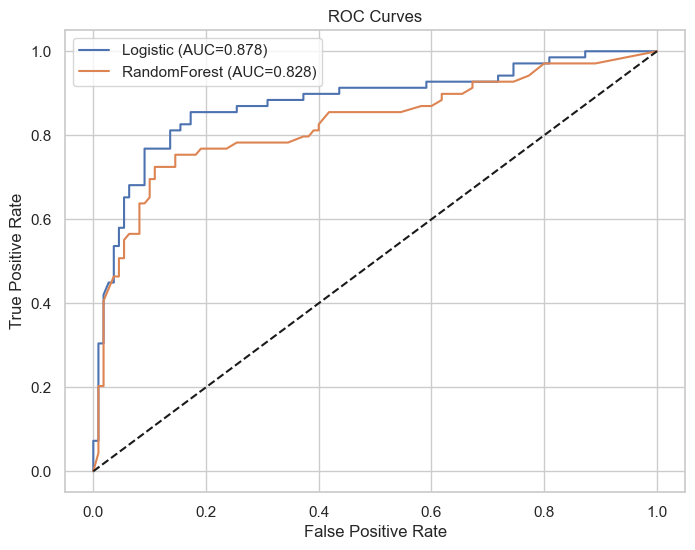

In [91]:
fpr_log, tpr_log, _ = roc_curve(y_val, y_prob_log)
fpr_rf, tpr_rf, _ = roc_curve(y_val, y_prob_rf)

plt.figure(figsize=(8,6))
plt.plot(fpr_log, tpr_log, label=f'Logistic (AUC={roc_auc_score(y_val,y_prob_log):.3f})')
plt.plot(fpr_rf, tpr_rf, label=f'RandomForest (AUC={roc_auc_score(y_val,y_prob_rf):.3f})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.show()


# 14) Feature importance (Random Forest)

To show feature importances we need the post-preprocessor feature names and the classifier's feature_importances_.


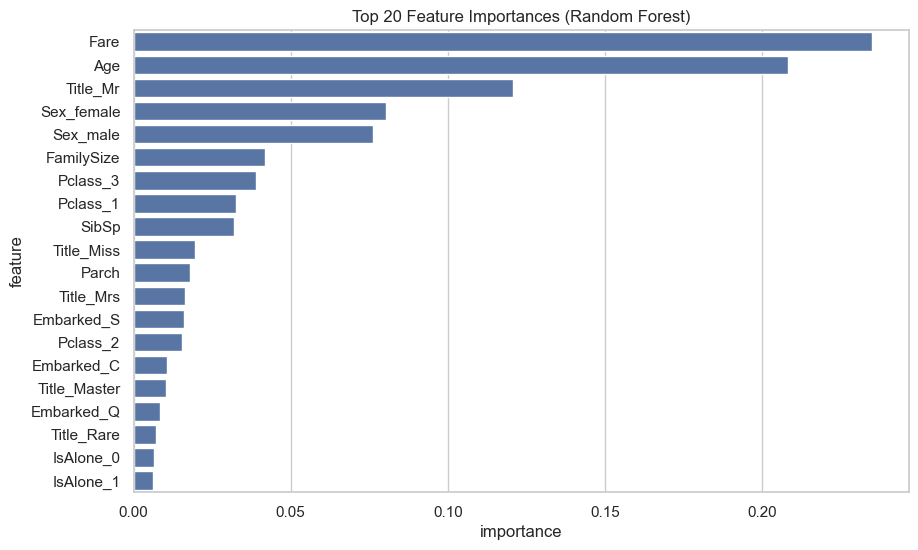

In [92]:
num_feats = numeric_features
ohe = rf_pipe.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']


try:
    cat_feature_names = list(ohe.get_feature_names_out(categorical_features))
except:
    cat_feature_names = []
    for i, cat in enumerate(categorical_features):
        cats = ohe.categories_[i]
        cat_feature_names += [f"{cat}_{c}" for c in cats]

feature_names = num_feats + cat_feature_names

# Get importances
importances = rf_pipe.named_steps['clf'].feature_importances_

# Build DataFrame and plot
feat_imp_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='importance', ascending=False).reset_index(drop=True)
plt.figure(figsize=(10,6))
sns.barplot(x='importance', y='feature', data=feat_imp_df.head(20))
plt.title("Top 20 Feature Importances (Random Forest)")
plt.show()


# 15) Hyperparameter tuning (Random Forest) — small GridSearchCV


In [93]:
param_grid = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [None, 6, 10],
    'clf__min_samples_split': [2, 5]
}

# Use GridSearchCV with a pipeline; scoring by accuracy
grid_search = GridSearchCV(rf_pipe, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

print("Best params:", grid_search.best_params_)
print("Best CV score:", grid_search.best_score_)

best_rf = grid_search.best_estimator_
# evaluate on validation set
y_pred_best = best_rf.predict(X_val)
y_prob_best = best_rf.predict_proba(X_val)[:,1]
print("Validation accuracy (best RF):", accuracy_score(y_val, y_pred_best))
print("Validation ROC AUC (best RF):", roc_auc_score(y_val, y_prob_best))


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best params: {'clf__max_depth': 10, 'clf__min_samples_split': 5, 'clf__n_estimators': 100}
Best CV score: 0.8217078695951937
Validation accuracy (best RF): 0.8324022346368715
Validation ROC AUC (best RF): 0.8432806324110672


In [94]:
grid_search.best_estimator_.fit(X_train, y_train)
y_pred_rf = grid_search.best_estimator_.predict(X_val)
y_prob_rf = grid_search.best_estimator_.predict_proba(X_val)[:,1]

print("\nRandom Forest")
print("Accuracy:", accuracy_score(y_val, y_pred_rf))
print(classification_report(y_val, y_pred_rf))
print("ROC AUC:", roc_auc_score(y_val, y_prob_rf))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred_rf))


Random Forest
Accuracy: 0.8324022346368715
              precision    recall  f1-score   support

           0       0.83      0.91      0.87       110
           1       0.83      0.71      0.77        69

    accuracy                           0.83       179
   macro avg       0.83      0.81      0.82       179
weighted avg       0.83      0.83      0.83       179

ROC AUC: 0.8432806324110672
Confusion Matrix:
 [[100  10]
 [ 20  49]]


# 16) Train both modes on the entire training dataset

Retrain the best model on full `train` data (not the local validation split) for final predictions on `test.csv`.


In [95]:
log_model = log_pipe
rf_model=grid_search.best_estimator_


# Fit on full training set
log_model.fit(X, y)
rf_model.fit(X, y)

print("Models trained on full training data.")


Models trained on full training data.


# 17) Create predictions for `test.csv` and build submission file

Kaggle expects a CSV with `PassengerId` and `Survived` columns.


In [96]:
# Ensure test has PassengerId
if 'PassengerId' not in test.columns:
    raise ValueError("test.csv must contain 'PassengerId' column for creating submission files.")

#Logistic Regression Submission
log_preds = log_model.predict(X_test_final)

submission_log = pd.DataFrame({
    "PassengerId": test['PassengerId'],
    "Survived": log_preds.astype(int)
})

submission_log_filename = "../data/submission_log.csv"
submission_log.to_csv(submission_log_filename, index=False)
print(f"Logistic Regression submission saved to {submission_log_filename}")
display(submission_log.head())

#Random Forest Submission
rf_preds = rf_model.predict(X_test_final)

submission_rf = pd.DataFrame({
    "PassengerId": test['PassengerId'],
    "Survived": rf_preds.astype(int)
})

submission_rf_filename = "../data/submission_rf.csv"
submission_rf.to_csv(submission_rf_filename, index=False)
print(f"Random Forest submission saved to {submission_rf_filename}")
display(submission_rf.head())


Logistic Regression submission saved to ../data/submission_log.csv


,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


Random Forest submission saved to ../data/submission_rf.csv


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


# 18) Save the final model to disk

Save the whole pipeline so that preprocessing is included.


In [97]:
model_filename_log = "../model/titanic_log_model.joblib"
model_filename_rf = "../model/titanic_rf_model.joblib"
joblib.dump(log_model, model_filename_log)
joblib.dump(rf_model, model_filename_rf)
print(f"Saved models pipeline to {model_filename_log}")
print(f"Saved models pipeline to {model_filename_rf}")

Saved models pipeline to ../model/titanic_log_model.joblib
Saved models pipeline to ../model/titanic_rf_model.joblib
